## Code cross-correlation

Par Réjane Joyard

### Importation des bibliothèques

In [9]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### Nom de fichier à analyser

In [10]:
filename = 'POC001FoxG1creGjb2floxflox-souris114OD-143734-40kHz-abr_res.mat'

### Fonction de cross-correlation

In [61]:
def calculer_seuil_cross_correlation(filename, risk, risk2, risk3):
    plt.figure(figsize=(5, 5))
    
    # Donnée
    data = loadmat(filename)
    
    # Paramètres récupérés du fichier .mat
    lmi = data['stimparams']['Lmin'][0][0][0][0]
    lmax = data['stimparams']['Lmax'][0][0][0][0]
    dl = data['stimparams']['delL'][0][0][0][0]
    L = np.flip(np.arange(lmi,lmax+1, np.abs(dl), dtype=int))
    t0 = 1e-3 * data['stimparams']['espace'][0][0][0][0] / 2
    ttube = 0.08 / 340
    tt = 1e3 * (data['tt1']-t0-ttube)
    fs = data['stimparams']['fech']
    gain = data['stimparams']['gain'][0][0][0][0]
    hrfac = 1e6 / gain
    
    # Définition des parties pre-signal et signal
    period_pre = tt[tt < 0]
    period_signal = np.arange(1/fs, 12+1/fs, 1/fs)  
    period_pre = len(period_pre)
    period_signal = len(period_signal)

    try:
        h = hrfac * data['hravsing']
    except AttributeError:
        h = hrfac * data['nrav']
    
    # Signal récupéré
    h = h - np.mean(h, axis=0)
    
    # Initialisation des seuils significatifs et du max de la seconde cross-correlation 
    xc_signal = np.zeros(len(L)-1)
    threshold = np.zeros(len(L)-1)
    threshold2 = np.zeros(len(L)-1)
    threshold3 = np.zeros(len(L)-1)
    
    # Boucle cross-correlation sur tous les signaux
    for i in range(len(L) - 1):
        previous_average = h[:, i]
        current_average = h[:, i + 1]
        # Première cross-correlation
        xc_pre = np.correlate(current_average[:period_pre], previous_average[period_pre:(period_pre + period_signal)], mode='full')
        # Seuil de significativité calculer à partir de la première cross-correlation avec 3 intervalles de confiance différents
        threshold[i] = np.mean(xc_pre) + norm.ppf(1-risk, 0, 1) * np.std(xc_pre)
        threshold2[i] = np.mean(xc_pre) + norm.ppf(1-risk2, 0, 1) * np.std(xc_pre)
        threshold3[i] = np.mean(xc_pre) + norm.ppf(1-risk3, 0, 1) * np.std(xc_pre)
        # Maximum de la seconde cross-correlation
        xc_signal[i] = np.max(np.correlate(current_average[period_pre:(period_pre + period_signal)], previous_average[period_pre:(period_pre + period_signal)], mode='full'))

    # Copie de la première valeur pour chaque tableau
    xc_signal = np.insert(xc_signal, 0, xc_signal[0])
    threshold = np.insert(threshold, 0, threshold[0])
    threshold2 = np.insert(threshold2, 0, threshold2[0])
    threshold3 = np.insert(threshold3, 0, threshold3[0])
    
    # Affichage de la max correlation et des seuils significatifs
    plt.plot(L[:len(xc_signal)], xc_signal, '-or', markerfacecolor='r')
    plt.plot(L[:len(threshold)], threshold, '--k') # 1e-5
    #plt.plot(L[:len(threshold2)], threshold2, '--m') # 1e-3
    #plt.plot(L[:len(threshold3)], threshold3, '--y') # 1e-2
    
    # Affichage en log
    #if np.all(threshold > 0) and np.all(xc_signal > 0):
        #plt.set_yscale('log')
    plt.xlabel('Level (dB SPL)')
    plt.ylabel('Cross-correlation max')
    plt.grid(False)
    
    # Condition : si le seuil de significativité est strictement supérieur au max(seconde cross-correlation) alors ne pas afficher le point en vert
    idx = np.where(xc_signal < threshold)[0]
    if len(idx) == 0 and np.all(xc_signal > threshold):
        plt.plot(L[:len(xc_signal)], xc_signal, 'ok', markerfacecolor='g', linewidth=2)
    elif len(idx) > 0 and idx[0] > 0:
        plt.plot(L[0:idx[0]], xc_signal[0:idx[0]], 'ok', markerfacecolor='g', linewidth=2)
    idxb = np.where(xc_signal < threshold)[0][-1] if len(np.where(xc_signal < threshold)[0]) > 0 else -1
    if idxb != -1 and idxb < len(xc_signal) - 1:
        plot_L = L[idxb+1:]
        plot_xc_signal = xc_signal[idxb+1:]
        if len(plot_L) == len(plot_xc_signal):
            plt.plot(plot_L, plot_xc_signal, 'ok', markerfacecolor='g', linewidth=2)
    
    # Calcul de l'interpolation
    c = np.where(np.diff(np.sign(xc_signal-threshold)))[0]
    if len(c) > 0:
        x1, x2 = L[c[0]], L[c[0]+1]
        y1, y2 = xc_signal[c[0]]-threshold[c[0]], xc_signal[c[0]+1]-threshold[c[0]+1]
        thrsh = x1 - y1 * (x2-x1) / (y2-y1)
        # Affichage du seuil exacte
        plt.axvline(x=thrsh, color='b', linestyle='--')
    else:
        # Sinon mettre le seuil à nan
        thrsh = np.nan
    
    # Affichage des légendes
    plt.legend(['Max correlation', 'Signif Threshold', 'Above Threshold','Threshold'], loc='best') # , 'Signif threshold 1e-3', 'Signif Threshold 1e-2'
    
    # Récupération du seuil (Si aucun seuil récupéré alors None)
    seuil = thrsh if thrsh is not None else None
    return seuil

### Application à la donnée

/var/folders/fc/qgg8t0j92nz99ysp4c8_7z_c0000gn/T/ipykernel_1320/1535092896.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  period_signal = np.arange(1/fs, 12+1/fs, 1/fs)


50.91339911747947

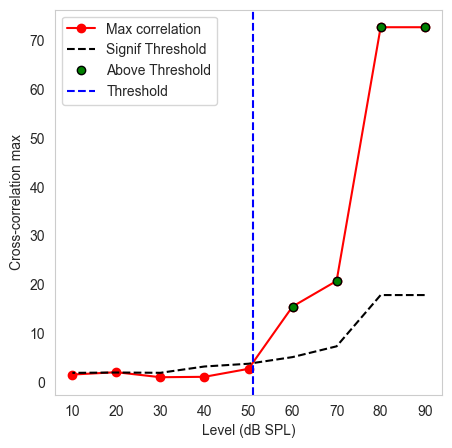

In [62]:
# Application de la fonction avec le fichier au choix et l'intervalle de confiance
calculer_seuil_cross_correlation(filename, risk=1e-5, risk2=1e-3, risk3=1e-2)

### Visualisation des signaux de la donnée

/var/folders/fc/qgg8t0j92nz99ysp4c8_7z_c0000gn/T/ipykernel_1320/3830710056.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  period_signal = np.arange(1/fs, 12+1/fs, 1/fs)


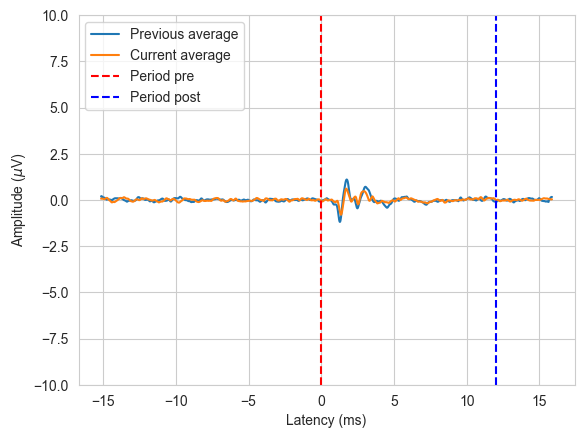

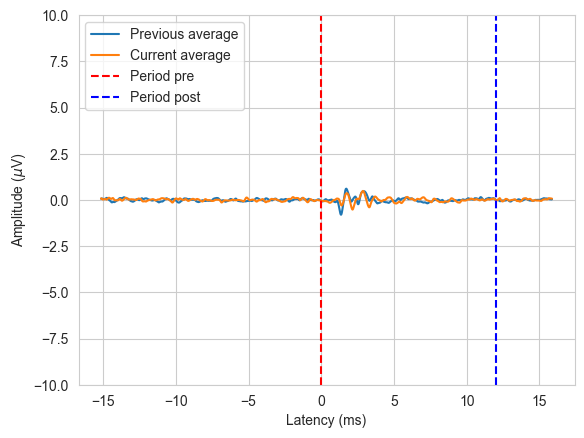

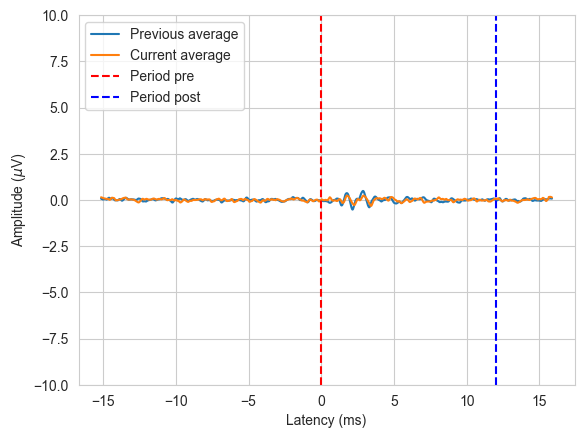

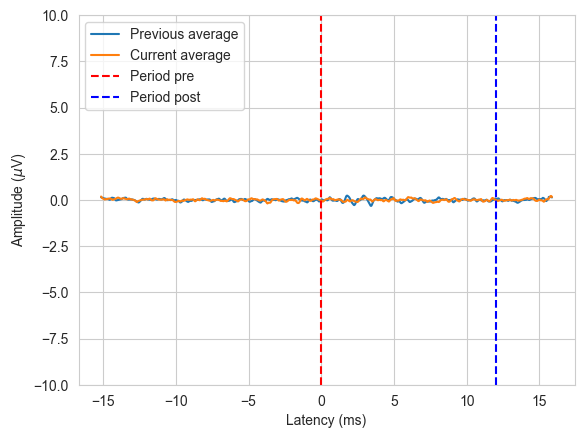

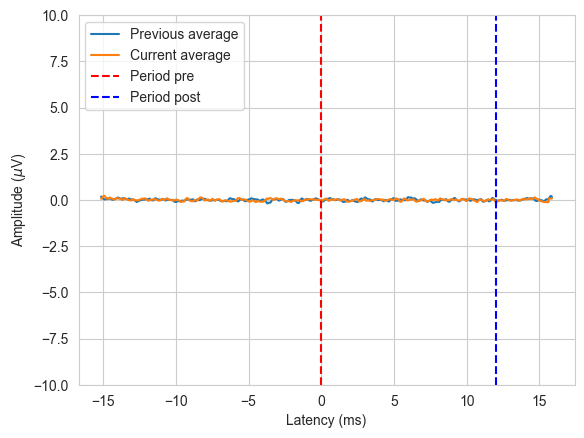

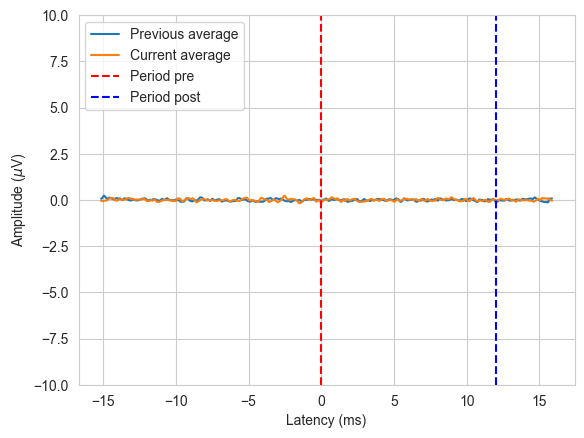

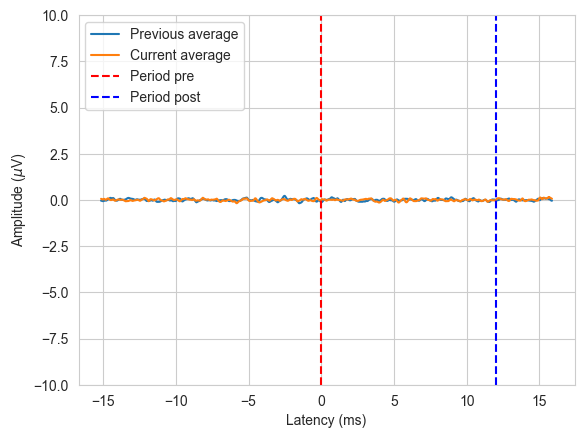

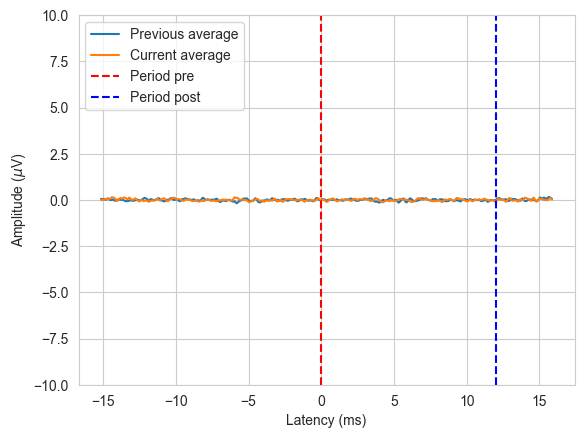

In [63]:
# Affichage de tous les signaux avec délimitation avant et après le signal

# Donnée
data = loadmat(filename)

# Paramètres récupérés du fichier .mat
lmi = data['stimparams']['Lmin'][0][0][0][0]
lmax = data['stimparams']['Lmax'][0][0][0][0]
dl = data['stimparams']['delL'][0][0][0][0]
L = np.flip(np.arange(lmi,lmax+1, np.abs(dl), dtype=int))
t0 = 1e-3 * data['stimparams']['espace'][0][0][0][0] / 2
ttube = 0.08 / 340
tt = 1e3 * (data['tt1']-t0-ttube)
fs = data['stimparams']['fech']
gain = data['stimparams']['gain'][0][0][0][0]
hrfac = 1e6 / gain

# Définition des parties pre-signal et signal
period_pre = tt[tt < 0]
period_signal = np.arange(1/fs, 12+1/fs, 1/fs)  
period_pre = len(period_pre)
period_signal = len(period_signal)

try:
    h = hrfac * data['hravsing']
except AttributeError:
    h = hrfac * data['nrav']

# Signal
h = h - np.mean(h, axis=0)

# Boucle d'affichage
for i in range(len(L)-1):
    previous_average = h[:, i]
    current_average = h[:, i+1]
    plt.figure()
    plt.plot(tt, previous_average, label='Previous average')
    plt.plot(tt, current_average, label='Current average')
    plt.ylim(-20,20)
    plt.axvline(0, color='r', linestyle='--', label='Period pre')
    plt.axvline(12, color='b', linestyle='--', label='Period post')
    plt.ylim(-10,10)
    plt.xlabel('Latency (ms)')
    plt.ylabel(r'Amplitude ($\mu$V)')
    plt.legend()   
    
plt.show()